In [1]:
%matplotlib inline

In [2]:
import warnings

# Supress specific warning by category
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.compose import AutoEnsembleForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.trend import TrendForecaster
from sktime.forecasting.trend import STLForecaster
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [4]:
train_file_path = '../data/train.csv'
output_file_path = '../data/test.csv'
horizon = 12

target = 'y'

## Data processing

In [5]:
ts = pd.read_csv(train_file_path, index_col=0).squeeze("columns")
ts.dropna(inplace=True, how='all')
ts.head()

01.01.15    1.91157
01.02.15    1.44733
01.03.15    1.89355
01.04.15    2.03274
01.05.15    2.27843
Name: y, dtype: float64

In [6]:
ts.index = pd.PeriodIndex(pd.to_datetime(ts.index, format='%d.%m.%y'), freq='M')
ts = ts.interpolate(method="time")
len(ts)

74

## Data modeling

In [7]:
y_train, y_test = temporal_train_test_split(ts, test_size=horizon)
fh = ForecastingHorizon(y_test.index, is_relative=False)

c:\Users\chubey\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\chubey\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\Users\chubey\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chubey\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\Users\chubey\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='y'>)

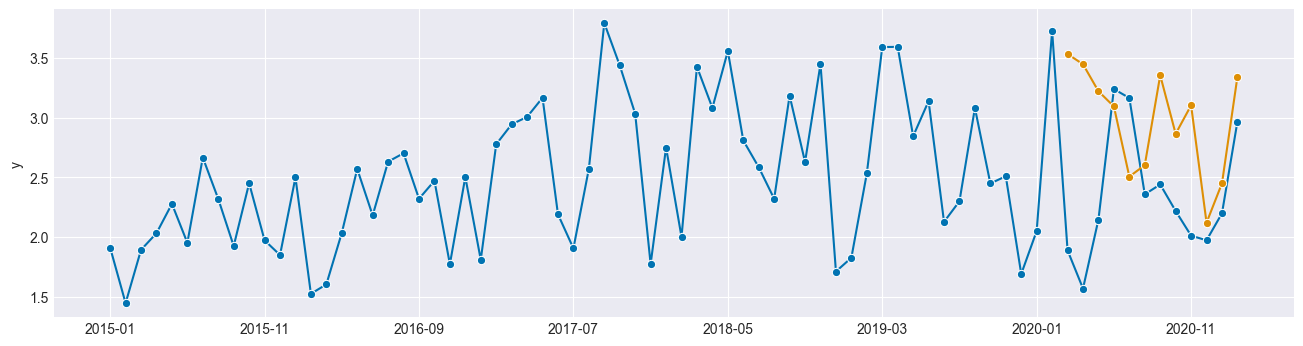

In [8]:
forecasters = [
    ("stl", STLForecaster(sp=12)),
    ("trend", TrendForecaster()),    
    ("naive", NaiveForecaster()),
    ("sarima", SARIMAX(order=(1, 0, 1), trend="t", seasonal_order=(0, 0, 1, 12))),
    ("arima", AutoARIMA()),
    ("exp", ExponentialSmoothing(trend='add', seasonal='additive', sp=12) )      
]
forecaster = AutoEnsembleForecaster(forecasters=forecasters)
forecaster.fit(y=y_train)
y_pred = forecaster.predict(fh)
plot_series(ts, y_pred)

In [9]:
mape = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mape:.2f}")

MAE: 0.76


## Final model training & inference

In [10]:
forecasters = [
    ("stl", STLForecaster(sp=12)),
    ("trend", TrendForecaster()),    
    ("naive", NaiveForecaster()),
    ("sarima", SARIMAX(order=(1, 0, 1), trend="t", seasonal_order=(0, 0, 1, 12))),
    ("arima", AutoARIMA()),
    ("exp", ExponentialSmoothing(trend='add', seasonal='additive', sp=12) ),
      
]
forecaster = AutoEnsembleForecaster(forecasters=forecasters)
forecaster.fit(y=ts)

c:\Users\chubey\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\chubey\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\Users\chubey\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chubey\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
c:\Users\chubey\Anaconda3\envs\timeseries\lib\site-packages\statsmodels\tsa\statespac

AutoEnsembleForecaster(forecasters=[('stl', STLForecaster(sp=12)),
                                    ('trend', TrendForecaster()),
                                    ('naive', NaiveForecaster()),
                                    ('sarima',
                                     SARIMAX(order=(1, 0, 1),
                                             seasonal_order=(0, 0, 1, 12),
                                             trend='t')),
                                    ('arima', AutoARIMA()),
                                    ('exp',
                                     ExponentialSmoothing(seasonal='additive',
                                                          sp=12,
                                                          trend='add'))])

In [11]:
y_train_index = y_train.index

# Create a ForecastingHorizon with 12 values
last_date = ts.index.max().to_timestamp() + pd.DateOffset(months=1)
fh = ForecastingHorizon(
                pd.PeriodIndex(pd.date_range(str(last_date), periods=horizon, freq='MS'), freq='M'),
                is_relative=False,
            )

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:ylabel='y'>)

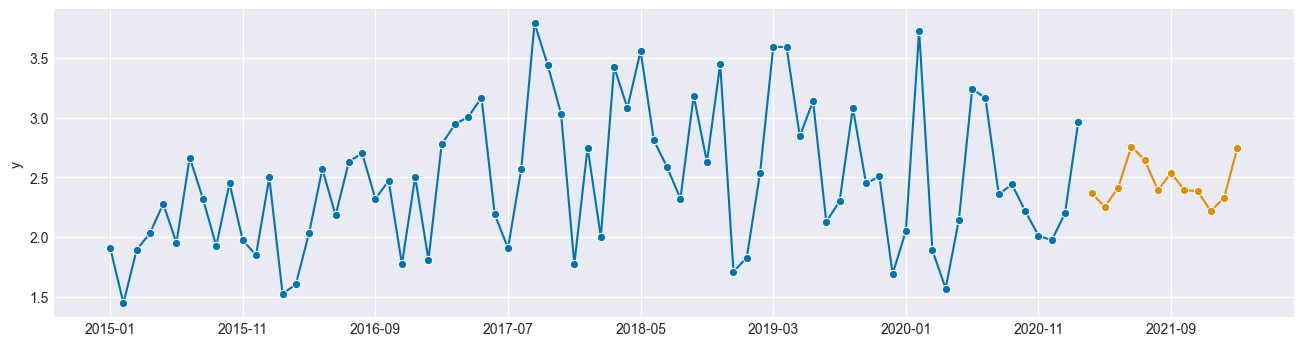

In [12]:
y_pred = forecaster.predict(fh)
plot_series(ts, y_pred)

In [13]:
df = pd.DataFrame(y_pred)
df.index = df.index.to_timestamp()
df.index = df.index.map(lambda x: x.replace(day=1))
df.index = df.index.strftime('%d.%m.%Y')

df.to_csv(output_file_path, index=True)

## Random Forest model

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

In [15]:
def add_date_features(data, date_column='date'):
    '''
    Function to add new features such as month and quarter
    Args:
        - data: DataFrame, the input dataframe
        - date_column: str, the name of the column containing the date information
    '''
    data['month'] = data[date_column].dt.month.astype('str')
    data['quarter'] = data[date_column].dt.quarter.astype('str')
    data.drop(columns=[date_column], inplace=True)
    return data

def add_lagged_features(data, target_column='target', lags=1):
    '''
    Function to add lagged target values to the dataframe
    Args:
        - data: DataFrame, the input dataframe
        - target_column: str, the name of the target column
        - lags: int, the number of lagged features to add
    '''
    for i in range(1, lags + 1):
        data[f'{target_column}_lag_{i}'] = data[target_column].shift(i)
    data.fillna(method='bfill', inplace=True)
    return data

def add_new_features(ts, target_column='target', lags=1):
    '''
    Function to add new features and lagged features to the dataframe
    Args:
        - ts: DataFrame, the input dataframe
        - target_column: str, the name of the target column
        - lags: int, the number of lagged features to add
    '''
    ts['date'] = ts.index.to_timestamp()
    ts = add_date_features(ts, 'date')
    ts = add_lagged_features(ts, target_column=target_column, lags=lags)
    return ts


In [16]:
df = pd.DataFrame(ts)

df = add_new_features(df, 'y', 12)

train, test = df.iloc[:-horizon], df.iloc[-horizon:]
X_train, y_train = train.drop(columns=['y']), train['y']
X_test, y_test = test.drop(columns=['y']), test['y']

cat_cols = X_train.select_dtypes(include='object').columns

pipeline = Pipeline([
    ('preprocessing', ColumnTransformer([('onehot', OneHotEncoder(), cat_cols)], remainder='passthrough')),
    ('classifier', RandomForestRegressor(random_state=42, max_depth=5, max_leaf_nodes=6))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.5823993549135277

Inference has some complexity as the model only predicts one-step-ahead.